In [129]:
import random_clip_forest
import torch

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.calibration import CalibratedClassifierCV
import torchvision.transforms.functional as fn
from torchvision.transforms import RandomAffine
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score


In [130]:
from transformers import BeitFeatureExtractor, BeitForImageClassification
from PIL import Image

In [131]:
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [171]:
# read in images
df = pd.read_csv('train_Kea.csv')
# throw away missing images
df = df.loc[df.image_id.apply(random_clip_forest.img_exists)]
df['Images'] = df['image_id'].apply(random_clip_forest.open_img_id)

df2 = df.copy()
df2['Images'] = df['Images'].apply(fn.hflip)

df3 = df.copy()
df3['Images'] = [fn.gaussian_blur(img=image,kernel_size=(9,9)) for image in df['Images']]

df = pd.concat([df, df2, df3])

labelsdf = pd.read_csv('labels.csv')
labels = labelsdf['object'].values.tolist()

In [172]:
y_train = np.array([
    random_clip_forest.onehot(lbl) for lbl in df['labels']
]).astype(int)

In [173]:
inputs = feature_extractor(images=df['Images'].tolist(), return_tensors="pt")


In [174]:
with torch.no_grad():
    outputs = model(**inputs)

In [175]:
X_train = outputs['logits']

In [176]:
####### Logistic regression #########
logres = LogisticRegression(dual=True, solver='liblinear', random_state=342985, max_iter=400, class_weight='balanced')
final = MultiOutputClassifier(logres)

In [177]:
final.fit(X_train, y_train) #logistic regression

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   dual=True, max_iter=400,
                                                   random_state=342985,
                                                   solver='liblinear'))

In [178]:
testdf = pd.read_csv('test.csv')
testlabels = []
labelsdf = pd.read_csv('labels.csv')
for img_id in testdf.image_id:
    try:
        inputs = feature_extractor([random_clip_forest.open_img_id(img_id)], return_tensors="pt")
        with torch.no_grad():
            x = model(**inputs)
        prediction = final.predict(x['logits'])
        predicted_labels = random_clip_forest.labelstring(prediction.astype(bool))

        if len(predicted_labels) == 0:
            testlabels.append('l1')
        else:
            testlabels.append(predicted_labels)
        print(img_id,
                ' '.join(labelsdf.loc[labelsdf.label_id.isin(testlabels[-1].split(' ')), 'object'].values.ravel()),
                sep='\t')
    except FileNotFoundError:
        print(img_id, 'missing, defaulting to l0')
        testlabels.append('l0')

img102.jpg	people buildings town hall of tartu estonian flag flags drone photography
img103.jpg	trees grass nature
img11.jpg	people snow man
img113.jpg	grass nature sunny plants
img114.jpg	flowers plants
img121.jpg	people trees grass buildings water sand playground lamp post beach
img126.jpg	people water
img131.jpg	people person glasses hands table
img136.jpg	people glasses
img137.jpg	trees snow
img139.jpg	trees
img140.jpg	trees sand
img15.jpg	green garbage can
img150.jpg	building buildings pavement street worker man
img151.jpg	building buildings road pavement
img152.jpg	people buildings road traffic signs
img156.jpg	trees road bicycle lamp post
img161.jpg	people trees water barge emajõe-peipsi barge jõmmu
img166.jpg	trees grass building person pavement crosswalk
img167.jpg	people grass road pavement car
img170.jpg	people trees building stone road table
img173.jpg	people trees snow
img176.jpg	people trees snow buildings stroller
img18.jpg	green garbage can
img180.jpg	people trees buil

In [179]:
testdf['labels'] = testlabels
testdf.to_csv('kea_submissions/beit_logreg_wscraped_vers3.csv', index=False) # Test mfscore ...

In [185]:
################# Ennustatud labelite exploration ###################
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

testdf = pd.read_csv('kea_submissions/beit_logreg_wscraped_vers3.csv')
labelsdf = pd.read_csv('labels.csv')
lbls_dict = dict(labelsdf.values)

human_lbls = []
for labels in testdf['labels']:
    lbls = np.str.split(labels, ' ')
    human = []
    [human.append(lbls_dict[l]) for l in lbls]
    human_lbls.append(human)

testdf['human'] = human_lbls

C:\Users\kohvk\AppData\Local\Temp\ipykernel_11852\252895335.py:14: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lbls = np.str.split(labels, ' ')


['person', 'cat']
img39.jpg


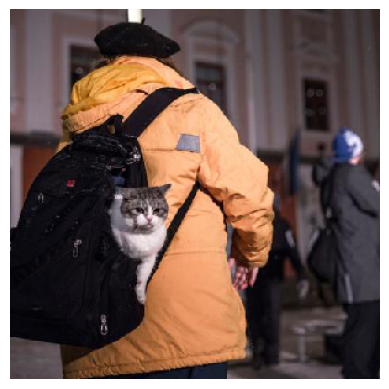

In [202]:
row_num = 68
img_id = testdf['image_id'][row_num]
image = tf.keras.preprocessing.image.load_img(os.path.join('images', img_id),
                    target_size=(300, 300),
                    keep_aspect_ratio = True,
                    color_mode = 'rgb')
print(testdf['human'][row_num])
plt.axis('off')
plt.imshow(image)
print(img_id)